# Script for demonstrating a CNN for genotyping from a sequence read pileup

In [139]:
import random
import numpy as np
NUCLEOTIDES = "ACGT"
random.seed(3)

## Function to simulate multiple sequence alignments with errors and either no SNP or heterozygous SNP

In [140]:
mutation_labels = {
    "no_SNP": 0,
    "heterozygous_SNP": 1,
    "homozygous_SNP": 2,
}

mutation_type_names = {0: "No mutation",
                 1: "Heterozygous SNP",
                 2: "Homozygous SNP"}

def simulate_alignments(reference_length=200, 
                        num_alignments = 2000, 
                        coverage = 100, 
                        mutations = mutation_labels.keys(),
                        p_sequencing_error=0.0,
                        p_alignment_error=0.00):
    alignments = []
    mutation_types = []
    
    for i in range(num_alignments):
        snp_index = reference_length // 2 
        if (i % 400 == 0):
            print("Computing alignment ", i)
        reference = [random.choice(NUCLEOTIDES) for _ in range(reference_length)]
        reference_base_at_snp = reference[snp_index]
        snp_base = random.choice([i for i in NUCLEOTIDES if i != reference_base_at_snp])
        mutation_type=random.choice([mutation_labels[m] for m in mutations]) 
        mutation_types.append(mutation_type)
        
        alignment = [reference] #first read is always the reference
        for _ in range(coverage):
            mut_index = snp_index
            new_read = [reference[i] if random.random() > p_sequencing_error else random.choice(NUCLEOTIDES) for i in range(reference_length)]
            if random.random() < p_alignment_error:
                mut_index = snp_index + random.randint(-1,2)
            if mutation_type == 1 and random.random() > 0.5: # heterozygous SNP
                new_read[mut_index] = snp_base            
            if mutation_type == 2: #homozygous SNP
                new_read[mut_index] = snp_base
            if random.random() < p_sequencing_error: #Add errors to SNP region also
                new_read[mut_index] =  random.choice(NUCLEOTIDES)
            alignment.append(new_read)
        alignments.append(alignment)
    return alignments, mutation_types

In [141]:
# Compute 2000 alignments
alignments, mutation_types = simulate_alignments(num_alignments=2000)
alignments = np.array(alignments)


Computing alignment  0
Computing alignment  400
Computing alignment  800
Computing alignment  1200
Computing alignment  1600


## Visualise the alignments

In [142]:
import matplotlib.pyplot as plt
%matplotlib inline

In [143]:
transdict = {"A":0, "C": 1, "G":2, "T":3}
alignments_ints = np.vectorize(transdict.get)(alignments)
plt.rcParams['figure.dpi'] = 200

### Example one: No mutation - no  errors

Mutation type:  No mutation


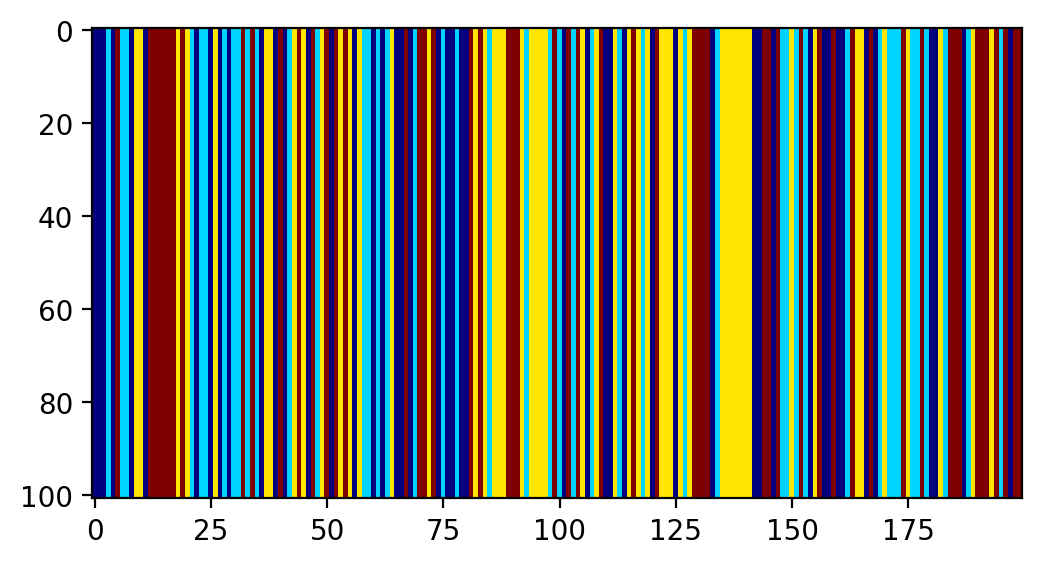

In [144]:
alignment_idx = mutation_types.index(0) # take the first example 
plt.imshow(alignments_ints[alignment_idx],cmap='jet')
print ("Mutation type: ", mutation_type_names[mutation_types[alignment_idx]])

### Example 2: Heterozygous mutation - no errors

Mutation type:  Heterozygous SNP


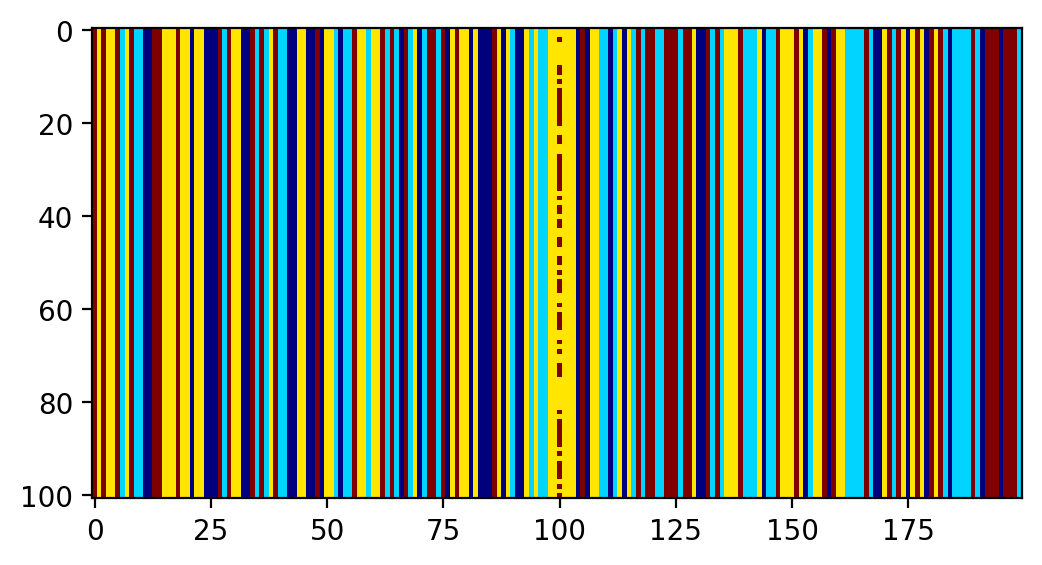

In [145]:
alignment_idx = mutation_types.index(1)
plt.imshow(alignments_ints[alignment_idx],cmap='jet')
print ("Mutation type: ", mutation_type_names[mutation_types[alignment_idx]])

### Example 3: Homozygous mutation - no errors

Mutation type:  Homozygous SNP


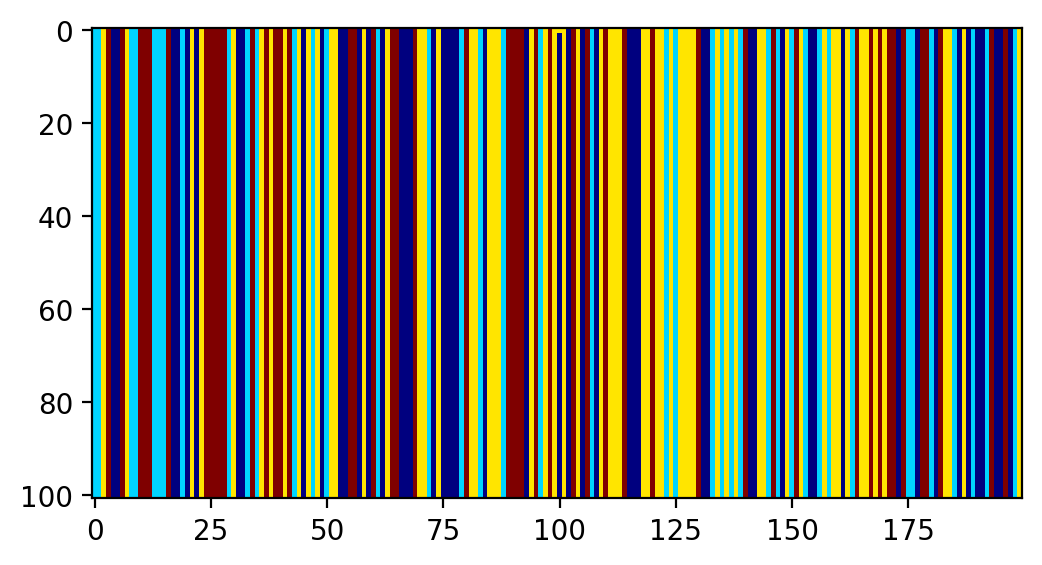

In [146]:
alignment_idx = mutation_types.index(2)
plt.imshow(alignments_ints[alignment_idx],cmap='jet')
print ("Mutation type: ", mutation_type_names[mutation_types[alignment_idx]])

### Example 4: No mutations, sequencing and alignment error

In [147]:
# Compute 2000 alignments
alignments, mutation_types = simulate_alignments(num_alignments=2000, p_alignment_error=0.025, p_sequencing_error=0.01)
alignments = np.array(alignments)
transdict = {"A":0, "C": 1, "G":2, "T":3}
alignments_ints = np.vectorize(transdict.get)(alignments)
plt.rcParams['figure.dpi'] = 200

Computing alignment  0
Computing alignment  400
Computing alignment  800
Computing alignment  1200
Computing alignment  1600


Mutation type:  Heterozygous SNP


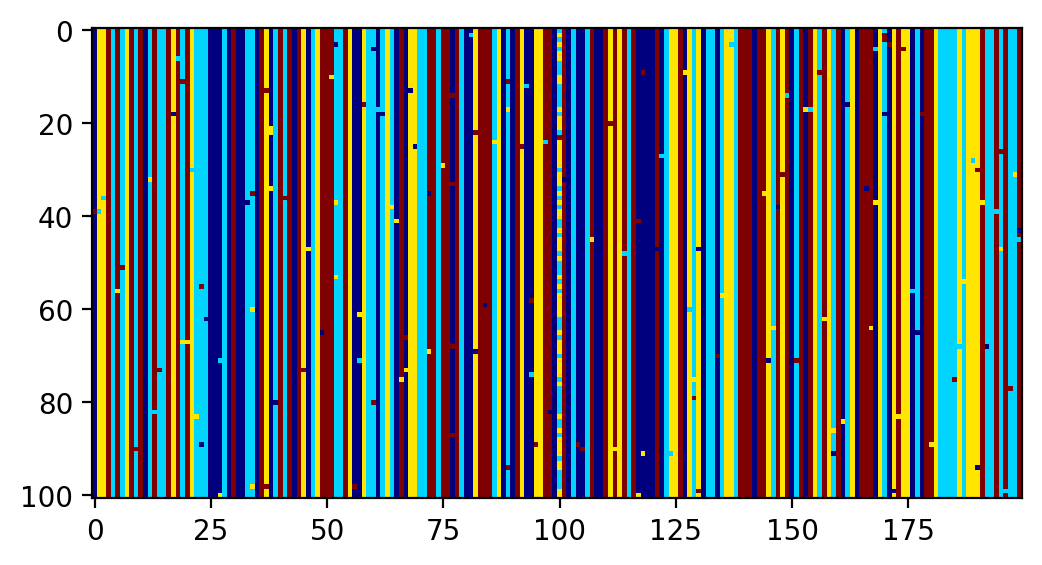

In [148]:
alignment_idx = mutation_types.index(1)
plt.imshow(alignments_ints[alignment_idx],cmap='jet')
print ("Mutation type: ", mutation_type_names[mutation_types[alignment_idx]])


## PyTorch Convolutional Neural Network Example

The SNP pileups visualised above are 2D arrays with shape `[101, 200]` that can be input to a neural network.

The output of the neural network can be a 2-dimensional vector containing the probability that the pileup contained no SNP or a heterozygous SNP.

The following demonstrates how to define a neural network with these inputs and outputs and train it on the alignments to predict the probabilities.

In [149]:
# define function to produce an array of the reference genome repeated - this is used as a second channel in CNN
def array_dup(arr):
    
    ref_gen = arr[0]
    
    ref_gen_matrix = np.tile(ref_gen,(101,1))

    aln_ref_dim = np.array((arr, ref_gen_matrix))
    
    return aln_ref_dim

In [150]:
# Compute 2000 alignments
alignments, mutation_types = simulate_alignments(num_alignments=2000, 
                                                 mutations=["no_SNP", "homozygous_SNP", "heterozygous_SNP"],
                                                 p_sequencing_error=0.02, # Define sequencing error
                                                 p_alignment_error=0.01) # Define alignment error

Computing alignment  0
Computing alignment  400
Computing alignment  800
Computing alignment  1200
Computing alignment  1600


In [151]:
alignments = [array_dup(i) for i in alignments]

In [152]:
alignments[175].shape

(2, 101, 200)

In [153]:
alignments[175] # Check out an alignment - CGAT

array([[['C', 'A', 'A', ..., 'A', 'A', 'A'],
        ['C', 'A', 'A', ..., 'A', 'A', 'A'],
        ['C', 'A', 'A', ..., 'A', 'A', 'A'],
        ...,
        ['C', 'A', 'A', ..., 'A', 'A', 'A'],
        ['C', 'A', 'A', ..., 'A', 'A', 'A'],
        ['C', 'A', 'A', ..., 'A', 'A', 'A']],

       [['C', 'A', 'A', ..., 'A', 'A', 'A'],
        ['C', 'A', 'A', ..., 'A', 'A', 'A'],
        ['C', 'A', 'A', ..., 'A', 'A', 'A'],
        ...,
        ['C', 'A', 'A', ..., 'A', 'A', 'A'],
        ['C', 'A', 'A', ..., 'A', 'A', 'A'],
        ['C', 'A', 'A', ..., 'A', 'A', 'A']]], dtype='<U1')

In [154]:
alignments = np.array(alignments)
transdict = {"A":0, "C": 1, "G":2, "T":3}
alignments_ints = np.vectorize(transdict.get)(alignments)

In [155]:
alignments_ints[175] # Check out the alignment - CGAT now transformed to numeric code

array([[[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]]])

In [156]:
# train on first 80% of data, validate on remaining 20%
mutation_types = np.array(mutation_types)

rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments_ints.shape[0])
rng.shuffle(idxs)

split_idx = int(alignments_ints.shape[0]*0.8)
train_alignments, valid_alignments = alignments_ints[idxs[:split_idx]], alignments_ints[idxs[split_idx:]]
train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]

Next define the neural network and training loop then train and evaluate the model:

In [157]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [158]:

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 6, 5) # input channels, output channels, kernel size
        self.conv2 = nn.Conv2d(6, 16, 5) # input channels, output channels, kernel size
        self.pool = nn.MaxPool2d(4, 4)
        self.fc1 = nn.Linear(16 * 5 * 11, 120) 
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 3) # Defines how many classes of outputs - 2 = yes/no; 3 = hom-ref, hom-nref, het

    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = self.fc3(x)
        #print(x.shape)
        return x


In [159]:
def train(model, train_alignments, train_mutation_types, valid_alignments, valid_mutation_types, epochs=10, lr=0.001):
    crit = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_alignments).float(), torch.tensor(train_mutation_types))
    valid_dataset = torch.utils.data.TensorDataset(torch.from_numpy(valid_alignments).float(), torch.tensor(valid_mutation_types))
    
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=16)
    
    train_losses, valid_losses, valid_accs = [], [], []
    
    for epoch in range(1, epochs + 1):
        # train for 1 epoch
        model = model.train()
        epoch_loss, total = 0.0, 0
        for i, (batch_alignment, batch_mutation_type) in enumerate(train_loader):
            opt.zero_grad()
            out = model(batch_alignment)
            loss = crit(out, batch_mutation_type)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
            total += 1
        epoch_loss /= total
        
        # compute validation loss and accuracy
        model = model.eval()
        valid_loss, n_correct, n, total = 0.0, 0, 0, 0
        for i, (batch_alignment, batch_mutation_type) in enumerate(valid_loader):
            with torch.no_grad():
                out = model(batch_alignment)
                loss = crit(out, batch_mutation_type)
                
            valid_loss += loss.item()
            total += 1

            predict = torch.nn.functional.softmax(out, dim=1).argmax(dim=1)
            correct = predict == batch_mutation_type
            n += out.shape[0]
            n_correct += correct.sum()
        valid_loss /= total
        accuracy = n_correct / n
        
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
        valid_accs.append(accuracy)
        print(f"epoch={epoch:2d}, train_loss={epoch_loss:.3f}, valid_loss={valid_loss:.3f}, accuracy={accuracy*100:.2f}%")
        
    return train_losses, valid_losses, valid_accs

In [160]:
model = CNN()
n_epochs = 15 # number of epochs
lr = 0.001 # learning rate

In [161]:
train_losses, valid_losses, valid_accs = train(model, train_alignments, train_mutation_types, valid_alignments, valid_mutation_types, epochs=n_epochs, lr=lr)


epoch= 1, train_loss=1.102, valid_loss=1.098, accuracy=36.75%
epoch= 2, train_loss=1.099, valid_loss=1.098, accuracy=33.00%
epoch= 3, train_loss=1.099, valid_loss=1.098, accuracy=33.00%
epoch= 4, train_loss=1.099, valid_loss=1.099, accuracy=33.00%
epoch= 5, train_loss=1.100, valid_loss=1.100, accuracy=33.00%
epoch= 6, train_loss=1.099, valid_loss=1.097, accuracy=33.00%
epoch= 7, train_loss=1.099, valid_loss=1.098, accuracy=33.00%
epoch= 8, train_loss=1.099, valid_loss=1.097, accuracy=33.00%
epoch= 9, train_loss=1.097, valid_loss=1.095, accuracy=39.00%
epoch=10, train_loss=1.098, valid_loss=1.097, accuracy=35.00%
epoch=11, train_loss=1.084, valid_loss=1.047, accuracy=44.25%
epoch=12, train_loss=0.915, valid_loss=0.727, accuracy=59.50%
epoch=13, train_loss=0.663, valid_loss=0.560, accuracy=69.00%
epoch=14, train_loss=0.497, valid_loss=0.270, accuracy=91.75%
epoch=15, train_loss=0.158, valid_loss=0.091, accuracy=97.25%


Computing the class probabilities for a single example using the trained model:

In [162]:
# Check out a particular SNP example
alignment_pick = 500

In [163]:
alignments_ints[alignment_pick][0].shape

(101, 200)

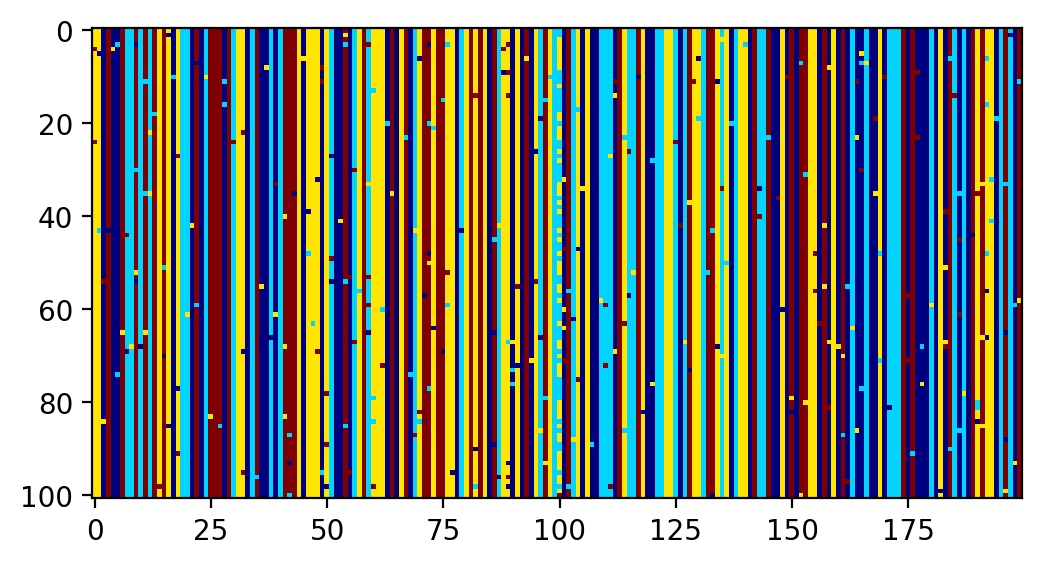

In [164]:
plt.imshow(alignments_ints[alignment_pick][0],cmap='jet')


In [165]:
with torch.no_grad():
    out = model(torch.from_numpy(alignments_ints[alignment_pick]).float().unsqueeze(0))[0]

out

tensor([-1.5979,  3.2278, -4.7408])

In [166]:
# Turn logits into probabilities using torch.softmax
# gives probabilities of "no_SNP" vs "heterozygous_SNP" vs "homozygous_SNP" according to the model

In [167]:
torch.softmax(out, dim=0)

tensor([7.9543e-03, 9.9170e-01, 3.4327e-04])